# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions. 
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

Required dependencies.

In [1]:
import os
import sys 
import json
import torch
import platform
import numpy as np
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader

In [2]:
# Check is at least python 3.9
assert (sys.version_info.major == 3) and (sys.version_info.minor > 9)

# Get os name
os_name = platform.system().lower()

# OS X
if 'darwin' in os_name:
    num_workers = 0
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # Set the device to mps (Apple Silicon GPU) if availaible for faster computation
    print("Detected OS X, device set to:", device)
# Linux 
elif 'linux' in os_name:
    device = torch.device("cpu")
    num_workers = 8
    print("Detected Linux, device set to:", device) 
# Windows 
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_workers = 0
    print("Detected Windows, device set to:", device)

Detected OS X, device set to: mps


## Load the image captioning dataset

Let's load the images, with their labels and caption.

In [3]:
def load_data(json_path, list, img_path):

    image_paths, texts, labels = [], [], []

    with open(json_path, 'r') as f:
        # Iterate over the lines in the file
        for line in f:
            # Load the JSON object from the line
            obj = json.loads(line)
            image_paths.append(os.path.join(img_path, obj['id'] + '.png'))

            texts.append(obj['text'])
            labels.append(obj['label'])
    images=[Image.open(img) for img in image_paths]

    for image, text, label in zip(images, texts, labels):
        item = {"image": image, "text": text, "label": label}
        list.append(item)

    print(f"Loaded {len(list)} memes from {json_path[17:]}")

In [4]:
topics = ['Base', 'Africans', 'Womens', 'Muslims']
img_path  = '../hateful_memes/img'

train_list_B = []
validation_list_B = []
test_list_B = []
train_list_W = []
validation_list_W = []
test_list_W = []
train_list_A = []
validation_list_A = []
test_list_A = []
train_list_M = []
validation_list_M = []
test_list_M = []

for topic in topics: 
    train_json_path = f'../hateful_memes/{topic}_train.jsonl'
    validation_json_path = f'../hateful_memes/{topic}_val.jsonl'
    test_json_path = f'../hateful_memes/{topic}_test.jsonl'

    # Get the first letter of the topic
    topic_initial = topic[0]

    # Use locals to access the correct list based on the topic
    load_data(train_json_path, locals()[f'train_list_{topic_initial}'], img_path)
    load_data(validation_json_path, locals()[f'validation_list_{topic_initial}'], img_path)
    load_data(test_json_path, locals()[f'test_list_{topic_initial}'], img_path)

Loaded 2414 memes from Base_train.jsonl
Loaded 604 memes from Base_val.jsonl
Loaded 504 memes from Base_test.jsonl
Loaded 1100 memes from Africans_train.jsonl
Loaded 276 memes from Africans_val.jsonl
Loaded 208 memes from Africans_test.jsonl
Loaded 838 memes from Womens_train.jsonl
Loaded 210 memes from Womens_val.jsonl
Loaded 204 memes from Womens_test.jsonl
Loaded 716 memes from Muslims_train.jsonl
Loaded 180 memes from Muslims_val.jsonl
Loaded 122 memes from Muslims_test.jsonl


Let's retrieve the caption and the corresponding image for each of our 3 topics:

Topic: Base - Caption: when a girl says she is lesbian so you become trans to smash modern problems require modern solutions - Label: 1
Topic: Africans - Caption: jamal! im pregnant!!! - Label: 0
Topic: Womens - Caption: there are 33 genders man, woman, and 31 types of queer - Label: 0
Topic: Muslims - Caption: when you're trying to listen to the teacher in your school and the foreign exchange student keeps on crying - Label: 0


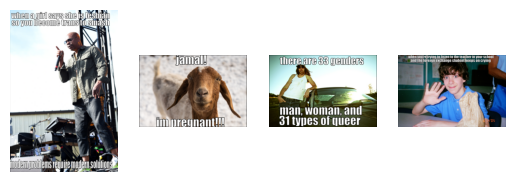

In [5]:
fig, axs = plt.subplots(1, len(topics))

for i, topic in enumerate(topics): 
    topic_initial = topic[0]
    print(f"Topic: {topic} - Caption: {locals()[f'train_list_{topic_initial}'][0]["text"]} - Label: {locals()[f'train_list_{topic_initial}'][0]["label"]}")
    axs[i].imshow(locals()[f'train_list_{topic_initial}'][0]["image"])
    axs[i].axis('off')

plt.show()

## Create PyTorch Dataset

Custom Dataset class

In [34]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        text = item["text"]
        label = item["label"]

        # Process the image, pt = PyTorch tensors
        processed_image = self.processor(images=image, return_tensors="pt")["pixel_values"]

        # Process the text, pt = PyTorch tensors
        processed_text = self.processor(text=[text], return_tensors="pt", padding=True, truncation=True)

        # Process the label
        label = torch.tensor(label)

        return processed_image, processed_text, label

## Load model and processor

In [35]:
class BLIPForClassification(nn.Module):
    def __init__(self, blip_model):
        super(BLIPForClassification, self).__init__()
        self.blip = blip_model
        self.classifier = nn.Linear(self.blip.config.text_config.hidden_size, 2)  # Adjust as per your classification needs
        self.loss_fn = nn.CrossEntropyLoss()  # Loss function for classification

    def forward(self, input_ids, pixel_values, attention_mask=None, labels=None):
        outputs = self.blip(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask, return_dict=True)
        
        # Inspect the output structure
        # Depending on the actual output, adjust the feature extraction
        text_embeds = outputs.last_hidden_state.mean(dim=1)  # Assuming last_hidden_state is available
        # For image features, you might need to adjust depending on actual model outputs
        image_embeds = outputs.pooler_output if 'pooler_output' in outputs else outputs.last_hidden_state.mean(dim=1)

        # Combining embeddings; you can choose a different strategy if required
        combined_embeds = text_embeds + image_embeds
        
        logits = self.classifier(combined_embeds)
        
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        
        return logits, loss  # Ensure the return is always a tuple

In [36]:
from transformers import AutoProcessor, BlipForConditionalGeneration

topics = ['Muslims']

model_B = None
model_W = None
model_A = None
model_M = None

# Create 4 CLIP models, one for each topic +1 base model
for topic in topics :

    topic_initial = topic[0]

    # Create a base CLIP model
    locals()[f'model_{topic_initial}'] = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
    processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

    # Freeze all parameters in the CLIP model
    for param in locals()[f'model_{topic_initial}'].parameters():
        param.requires_grad = False

    # Add the classification head
    locals()[f'model_{topic_initial}'] = BLIPForClassification(locals()[f'model_{topic_initial}'])

    # Unfreeze the classification head
    for param in locals()[f'model_{topic_initial}'].classifier.parameters():
        param.requires_grad = True
    
    print(f"Succesfully created model_{topic_initial}.")

Succesfully created model_M.


Compute model size and display model architecture

In [37]:
save = False
if save:
    # Save the model paramters to estimate the size of the model: CLIP = 605 MB
    torch.save(model_B.state_dict(), "CLIP_size.pth")
    # Display the model summary
    #(C, H, W): number of channels (C), height (H), and width (W) of the input image.
    input_size = (3, 224, 224) 
    summary(model_B, input_size)

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [38]:
def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    
    # Collect all text dictionaries
    text_dicts = [item[1] for item in batch]
    
    # Create a new dictionary to store the concatenated texts
    collated_texts = {}
    
    # Iterate over keys in the first text dictionary to handle padding
    for key in text_dicts[0].keys():
        max_length = max([text_dict[key].shape[1] for text_dict in text_dicts])
        padded_texts = [torch.nn.functional.pad(text_dict[key], (0, max_length - text_dict[key].shape[1])) for text_dict in text_dicts]
        collated_texts[key] = torch.cat(padded_texts, dim=0)
    
    labels = torch.tensor([item[2] for item in batch])
    return images, collated_texts, labels

In [39]:
train_loader_B = None
validation_loader_B = None
test_loader_B = None

train_loader_W = None
validation_loader_W = None
test_loader_W = None

train_loader_A = None
validation_loader_A = None
test_loader_A = None

train_loader_M = None
validation_loader_M = None
test_loader_M = None

for topic in topics:
    
    topic_initial = topic[0]

    # Build the train and validation datasets
    train_dataset      = ImageCaptioningDataset(locals()[f'train_list_{topic_initial}'], processor)
    validation_dataset = ImageCaptioningDataset(locals()[f'validation_list_{topic_initial}'], processor)
    test_dataset       = ImageCaptioningDataset(locals()[f'test_list_{topic_initial}'], processor)

    # Create loaders
    locals()[f'train_loader_{topic_initial}'] = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=num_workers, collate_fn=collate_fn)
    locals()[f'validation_loader_{topic_initial}'] = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
    locals()[f'test_loader_{topic_initial}'] = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

    print(f"Succesfully created loaders for model_{topic_initial}.")

Succesfully created loaders for model_M.


## Train the model

Let's train the model! Run the simply the cell below for training the model

In [40]:
@torch.no_grad()
def test(model: nn.Module, loader: DataLoader, device: torch.device):
    """The test function, computes the F1 score of the current model on the validation/test loader

    Args:
        model (nn.Module): The model to evaluate
        loader (DataLoader): The data loader to iterate on the dataset to validate/test

    Returns:
        f1 (float): The F1 score on the given dataset
        loss (float): Averaged loss on the given dataset
    """
    model.eval()

    preds_dict = {"preds": torch.tensor([], dtype=torch.long), 
                  "labels": torch.tensor([], dtype=torch.long), 
                  "losses": torch.tensor([], dtype=torch.float)}

    for batch in loader:
        images, texts, labels = batch
        images = images.squeeze(1).to(device)
        texts = {key: value.to(device) for key, value in texts.items()}
        labels = labels.to(device)

        # Forward pass
        preds, _ = model(pixel_values=images, input_ids=texts["input_ids"], attention_mask=texts["attention_mask"], labels=labels)
        
        loss = F.cross_entropy(preds, labels)
        
        # Store values back to the CPU before storing them in preds_dict. This is because PyTorch tensors on the GPU cannot be converted to NumPy arrays, which is what f1_score requires.
        preds_dict["preds"] = torch.cat([preds_dict["preds"], preds.argmax(1).cpu()])
        preds_dict["labels"] = torch.cat([preds_dict["labels"], labels.cpu()])
        preds_dict["losses"] = torch.cat([preds_dict["losses"], loss[None].cpu()])

    # Compute metric and loss
    f1 = f1_score(preds_dict["labels"].numpy(), preds_dict["preds"].numpy(), average="macro")
    loss = preds_dict["losses"].mean().item()

    return f1, loss

In [41]:
def train(model : nn.Module, train_loader : DataLoader, val_loader : DataLoader, n_epochs : int, optimizer : torch.optim.Optimizer, device : torch.device, scheduler = None):
    """Trains the neural network self.model for n_epochs using a given optimizer on the training dataset.
    Outputs the best model in terms of F1 score on the validation dataset.

    Args:
        model (nn.Module): The model to train
        train_loader (DataLoader): The training dataloader to iterate on the training dataset
        val_loader (DataLoader): The validation dataloader to iterate on the validation dataset
        n_epochs (int): The number of epochs, i.e. the number of time the model should see each training example
        optimizer (torch.optim.Optimizer): The optimizer function to update the model parameters

    Returns:
        best_model (nn.Module): Best model state dictionary 
        best_f1 (float): Best F1-score on the validation set
        best_epoch (int): Best epoch on validation set
        val_f1s (list of floats): (n_epochs, ) F1-scores for all epochs
        val_losses (list of floats): (n_epochs, ) Losses for all validation epochs
        train_losses(list of floats): (n_epochs, ) Losses for all training epochs
    """

    # Initialize variable to return
    best_model = model.state_dict()
    best_epoch = 0
    best_f1 = 0
    train_losses = []
    val_losses = []
    val_f1s = []
    f1 = 0
    val_loss = 0

    for epoch in range(n_epochs):
        running_loss = 0.0
        for batch in train_loader:
            images, texts, labels = batch
            images = images.squeeze(1).to(device)
            texts = {key: value.to(device) for key, value in texts.items()}
            labels = labels.to(device)

            # Forward pass
            outputs, _ = model(pixel_values=images, input_ids=texts["input_ids"], attention_mask=texts["attention_mask"], labels=labels)

            loss = F.cross_entropy(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        with torch.no_grad():
            [f1, val_loss] = test(model, val_loader, device)
            val_f1s.append(f1)
            val_losses.append(val_loss)

            scheduler.step(val_loss)
            current_lr = scheduler.optimizer.param_groups[0]['lr']

            if f1 > best_f1: 
                best_model = model.state_dict()
                best_f1 = f1
                best_epoch = epoch + 1

        print(f'Epoch {epoch + 1} - F1: {f1:.3f} - Validation Loss: {val_loss:.3f} - Training Loss: {running_loss / len(train_loader):.3f} - LR: {current_lr:.6f}')

    return best_model, best_f1, best_epoch, val_f1s, val_losses, train_losses

In [42]:
training_active = True

try:
    for topic in topics:
        topic_initial = topic[0]
        if training_active:

            locals()[f'model_{topic_initial}'].train()
            locals()[f'model_{topic_initial}'].to(device)

            optimizer = torch.optim.AdamW(locals()[f'model_{topic_initial}'].parameters(), lr=5e-4)

            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=2)

            epochs = 15

            print(f"Training model_{topic_initial} for {epochs} epochs...")
            # Run training and display results:
            best_model, best_f1, best_epoch, val_accs, val_loss, train_loss = train(locals()[f'model_{topic_initial}'], locals()[f'train_loader_{topic_initial}'], locals()[f'validation_loader_{topic_initial}'], n_epochs=epochs, optimizer=optimizer, device=device, scheduler=scheduler)
            print(f"Best model at epoch {best_epoch} -> {100*best_f1:.2f}% F1 score")

            # Save the state dictionary
            torch.save(best_model, f'BLIP_{topic_initial}_trained.pth')

            locals()[f'model_{topic_initial}'] = locals()[f'model_{topic_initial}'].to(device)  # Move the model to the device
            locals()[f'model_{topic_initial}'].eval();  # Set the model to evaluation mode

        else:
            # Check if the file exists before trying to load it
            if os.path.exists(f'CLIP_{topic_initial}_trained.pth'):
                locals()[f'model_{topic_initial}'] = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
                locals()[f'model_{topic_initial}'] = BLIPForClassification(locals()[f'model_{topic_initial}'])       # Add the classification head
                locals()[f'model_{topic_initial}'].load_state_dict(torch.load(f'BLIP_{topic_initial}_trained.pth'))  # Load the state_dict
                locals()[f'model_{topic_initial}'] = locals()[f'model_{topic_initial}'].to(device)                   # Move the model to the device
                locals()[f'model_{topic_initial}'].eval();                                                           # Set the model to evaluation mode
                locals()[f'model_{topic_initial}'].to(device)                                                        # Move the model to the device
                print(f"Succesfully loaded saved weights for model_{topic_initial}.")
            else:
                print(f"No pre-trained model found for model_{topic_initial}.")
                locals()[f'model_{topic_initial}'] = None
except KeyboardInterrupt:
    print("Training interrupted. Saving model and outputs...")
    # Save the state dictionary
    torch.save(best_model, f'BLIP_{topic_initial}_trained.pth')

    locals()[f'model_{topic_initial}'] = locals()[f'model_{topic_initial}'].to(device)  # Move the model to the device
    locals()[f'model_{topic_initial}'].eval();  # Set the model to evaluation mode
        

Training model_M for 15 epochs...
Epoch 1 - F1: 0.408 - Validation Loss: 0.656 - Training Loss: 0.604 - LR: 0.000500
Training interrupted. Saving model and outputs...


NameError: name 'best_model' is not defined

In [ ]:
def plot_training(best_epoch: int, val_accs: list, val_loss: list, train_loss: list):
    """Plot training results of linear classifier
    
    Args:
        best_epoch (int): Best epoch
        val_accs (List): (E,) list of validation measures for each epoch
        val_loss (List): (E,) List of validation losses for each epoch
        train_loss (List): (E,) List of training losses for each epoch
    """

    # Create plot
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    es = np.arange(1, len(val_accs)+1)
    # Plot F1 score
    axes[0].plot(es, val_accs, label="Val")
    axes[0].vlines(best_epoch, ymin=np.min(val_accs), ymax=np.max(val_accs), color='k', ls='--', label="Best epoch")
    axes[0].set_xlabel("Training steps")
    axes[0].set_ylabel("F1-score")
    axes[0].set_title("F1-score")
    axes[0].legend()

    # Plot losses
    axes[1].plot(es, val_loss, label="Val")
    axes[1].plot(es, train_loss, label="Train")
    axes[1].vlines(best_epoch, ymin=np.min(train_loss), ymax=np.max(val_loss), color='k', ls='--', label="Best epoch")
    axes[1].set_xlabel("Training steps")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Losses")
    axes[1].legend()
    
    plt.tight_layout()

# Plot results
# for topic in topics:
#     if training_active:
#         plot_training(best_epoch=best_epoch, val_accs=val_accs, val_loss=val_loss, train_loss=train_loss)

## Inference

Let's check the results on our validation set:

In [ ]:
for topic in topics:
    topic_initial = topic[0]
    # check that the model is loaded correctly
    if locals()[f'model_{topic_initial}'] is not None:
        print(f"Model_{topic_initial} F1 score on the training set: {test(locals()[f'model_{topic_initial}'], locals()[f'train_loader_{topic_initial}'], device)[0]:.3f}")
        print(f"Model_{topic_initial} F1 score on the validation set: {test(locals()[f'model_{topic_initial}'], locals()[f'validation_loader_{topic_initial}'], device)[0]:.3f}")
        print(f"Model_{topic_initial} F1 score on the testing set: {test(locals()[f'model_{topic_initial}'], locals()[f'test_loader_{topic_initial}'], device)[0]:.3f}")

In [ ]:
def predict_image(model: nn.Module, loader: DataLoader, device: torch.device, index: int):

    model.eval()
    
    # Only process the first batch
    for batch in loader:
        images, texts, labels = batch
        images = images.squeeze(1).to(device)
        texts = {key: value.to(device) for key, value in texts.items()}
        labels = labels.to(device)
        
        # Forward and loss
        preds, _ = model(pixel_values=images, input_ids=texts["input_ids"], attention_mask=texts["attention_mask"])

        # Plot the specified image, its prediction, and the true label
        image = images[index].cpu().numpy().transpose(1, 2, 0)  # Assuming images are in (C, H, W) format
        # Ensure image is in the correct range
        image = np.clip(image, 0, 1)

        true_label = labels[index].item()
        predicted_label = preds.argmax(1)[index].item()

        plt.imshow(image)
        plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
        plt.axis('off')
        plt.show()
        
        break  # Exit after processing the first batch

# Predict an image
predict_image(model_M, test_loader_M, device, index=0)